In [2]:
import sys
sys.path.append('../')

import torch
import numpy as np
import pandas as pd
import torch.nn.functional as F
from torch.utils.data import Dataset

from MyPlot import *
from utils import force, fd_solve_nlinear
from ConstCofFVM import UniformFVM, BlockCofProblem
from BaseTester import BaseTester

In [7]:

class C2TestDs(Dataset):
	def __init__(self, F, M, U, dtype, device):
		self.force = torch.from_numpy(F).to(dtype).to(device)
		self.mus = torch.from_numpy(M).to(dtype).to(device)
		self.refs = torch.from_numpy(U).to(dtype).to(device)

	def __len__(self):
		return self.mus.shape[0]

	def __getitem__(self, index):
		f = self.force[index]
		mu = self.mus[index]
		u = self.refs[index]

		data = torch.stack([f, mu])[None, ...]
		return data, f, mu, u
	
class nonlinearTester(BaseTester):
	def __init__(self, **kwargs):
		super().__init__(**kwargs)
		self.mesh()

	def init_test_ds(self, DataN, load_path=None):
		F = np.load(f"{load_path}/{self.GridSize}/F.npy")
		M = np.load(f"{load_path}/{self.GridSize}/MU.npy")
		U = np.load(f"{load_path}/{self.GridSize}/U.npy")
		print(M.shape)
		self.ds = C2TestDs(F[:DataN], M[:DataN], U[:DataN], self.dtype, self.device)

	def hard_encode(self, x, gd):
		y = F.pad(x, (1, 1, 1, 1), 'constant', value=gd)
		return y
	
	def test(self,exp_name, DataN, best_or_last, load_path):
		self.load_kwargs(exp_name)
		self.init_test_ds(DataN, load_path)
		self.load_ckpt(best_or_last, exp_name)

		df = {
			'l2': []
		}

		with torch.no_grad():
			for i, (data, force, mu, ans) in enumerate(self.ds):
				pre = self.net(data)
				pre = self.hard_encode(pre, gd=0)
				l2 = self.l2(pre, ans)	

				mu = mu.mean().item()
				
				df['l2'].append(l2.item())

				# if l2 < 1e-3:
		self.save_img(f"{self.img_save_path}/{exp_name}/TestCase-{i}-{mu:.4e}", pre, ans, force, mu)
		
		df = pd.DataFrame(df)
		df.to_csv(f"{self.img_save_path}/{exp_name}/l2.csv", index=False)
	
	def save_img(self, path, pre, ans, force, mu):
		p = Path(path)
		if not p.is_dir():
			p.mkdir(parents=True)
		plt.rcParams['font.size'] = 18  # Default font size


		pre = pre.cpu().numpy().reshape(self.GridSize, self.GridSize)
		force = force.cpu().numpy().reshape(self.GridSize, self.GridSize)
		ans = ans.cpu().numpy().reshape(self.GridSize, self.GridSize)
		
		save_surf(path, pre, self.xx, self.yy, 'surf_pre')
		save_surf(path, ans, self.xx, self.yy, 'surf_ref')
		save_ctf(path, pre, ans, self.xx, self.yy)
		save_contour(path, pre, ans, self.xx, self.yy, levels=None)
		save_img_force(path, force, 'force')

In [ ]:
GridSize = 128
DataN = 2000

nonlinear_tester = nonlinearTester(
    GridSize=GridSize,
    area=((0, 0), (1, 1)),
    ckpt_save_path=f'model_save',
    hyper_parameters_save_path = f'hyper_parameters', 
    img_save_path = f'./images', 
    device='cuda',
    dtype=torch.float,
	)

exp_name = 'Picard=5-ResBottleNeck-8-4#4#6#6#8-2-relu-layer-avg-zeros-GridSize:128-maxiter:10-trainN:10000-bs:5'
best_or_last = 'last'
nonlinear_tester.test(exp_name, DataN, best_or_last, './TestData')


In [ ]:
# df = pd.read_csv('Ju-ResBottleNeck-2#2#4#6#6-2#2#4#6#6-2-layer-avg-replicate-GridSize:128-maxiter:5-trainN:10000-bs:5.csv')
df = pd.read_csv('l2.csv')
errors = df['l2'].values
errors = errors.reshape(9, 9)
# plt.imshow(errors)
# plt.colorbar()

from MyPlot import *

save_img_force('./test_mu2.png', errors, name='$L_2$ Errors')


0.00149580227428664


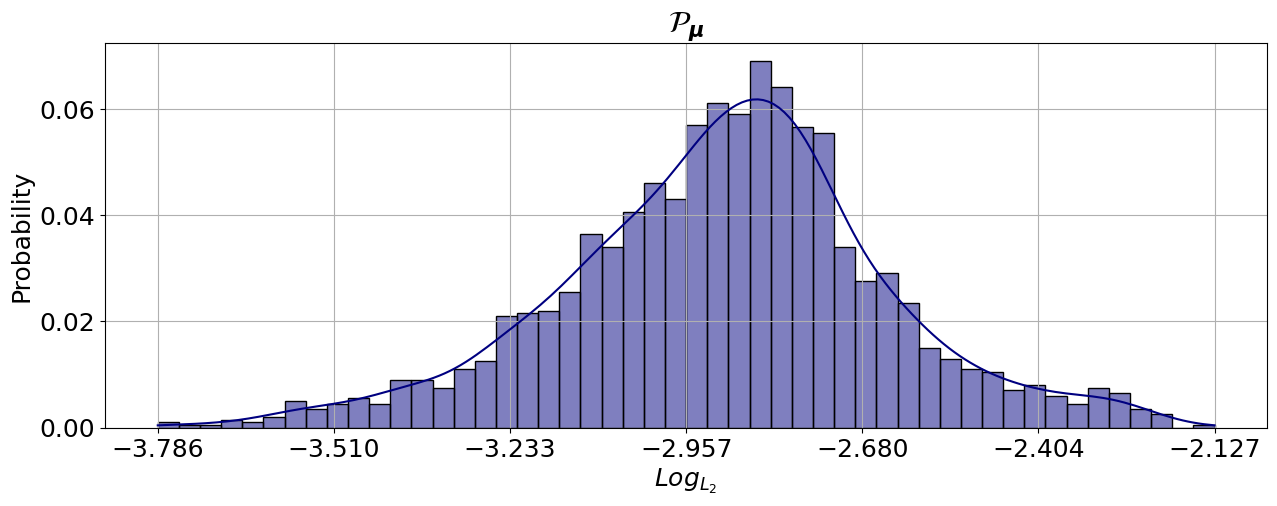

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
df = pd.read_csv('./l2.csv')

fig = plt.figure(figsize=(15, 5))  # Set the figure size
plt.rcParams['font.size'] = 18  # Default font size
data = np.log10(df['l2'].values)
sns.histplot(
data,
bins=50,  # Number of bins
kde=True,  # Add KDE (Kernel Density Estimate)
stat='probability',  # Normalize the histogram
color='navy',  # Color of the bars
edgecolor='black'  # Color of the edges
)
print(df['l2'].mean())

# Customization
plt.title(r'$\mathcal{P}_\boldsymbol{\mu}$')  # Title of the plot
plt.xlabel('$Log_{L_2}$')  # X-axis label
plt.xticks(np.linspace(data.min(), data.max(), 7))
plt.ylabel('Probability')  # Y-axis label
plt.grid(True)  # Show grid lines
plt.show()
fig.savefig(f'test_all.png')
plt.close()
